In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.4


# Interpolation with PyMC3

## A 1D example

To start, we'll do a simple 1D example where we have a model evaluated at control points and we interpolate between them to estimate the model value.

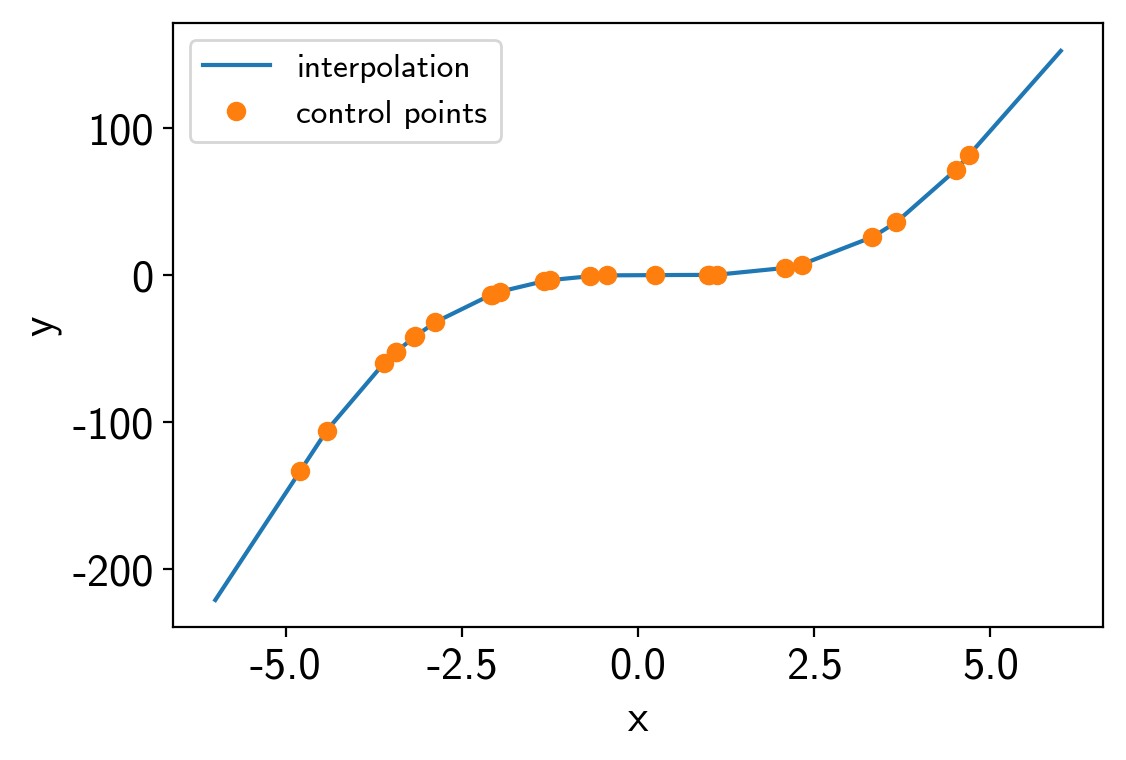

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(42)
x = np.sort(np.random.uniform(-5, 5, 25))
points = [x]
values = x**3-x**2

interpolator = xo.interp.RegularGridInterpolator(points, values[:, None])

t = np.linspace(-6, 6, 5000)
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.plot(x, values, "o", label="control points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

Here's how we build the PyMC3 model:

In [4]:
import pymc3 as pm

truth = 45.0
data_sd = 8.0
data_mu = truth + data_sd * np.random.randn()

with pm.Model() as model:
    
    # The value passed into the interpolator must have the shape
    # (ntest, ndim), but in our case that is (1, 1)
    xval = pm.Uniform("x", lower=-8, upper=8, shape=(1, 1))
    
    # Evaluate the interpolated model and extract the scalar value
    # we want
    mod = pm.Deterministic("y", interpolator.evaluate(xval)[0, 0])
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=1000, tune=2000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [x]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [00:00<00:01, 6529.59draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [00:00<00:01, 6800.47draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [00:00<00:01, 7039.84draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [00:00<00:01, 7356.30draws/s]

Sampling 4 chains:  32%|███▏      | 3880/12000 [00:00<00:01, 7743.55draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [00:00<00:00, 7963.43draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [00:00<00:00, 7952.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [00:00<00:00, 8209.06draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [00:00<00:00, 7845.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [00:01<00:00, 7857.69draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [00:01<00:00, 8456.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [00:01<00:00, 7925.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10784/12000 [00:01<00:00, 8245.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [00:01<00:00, 7142.88draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:01<00:00, 7340.55draws/s]

And here are the results:

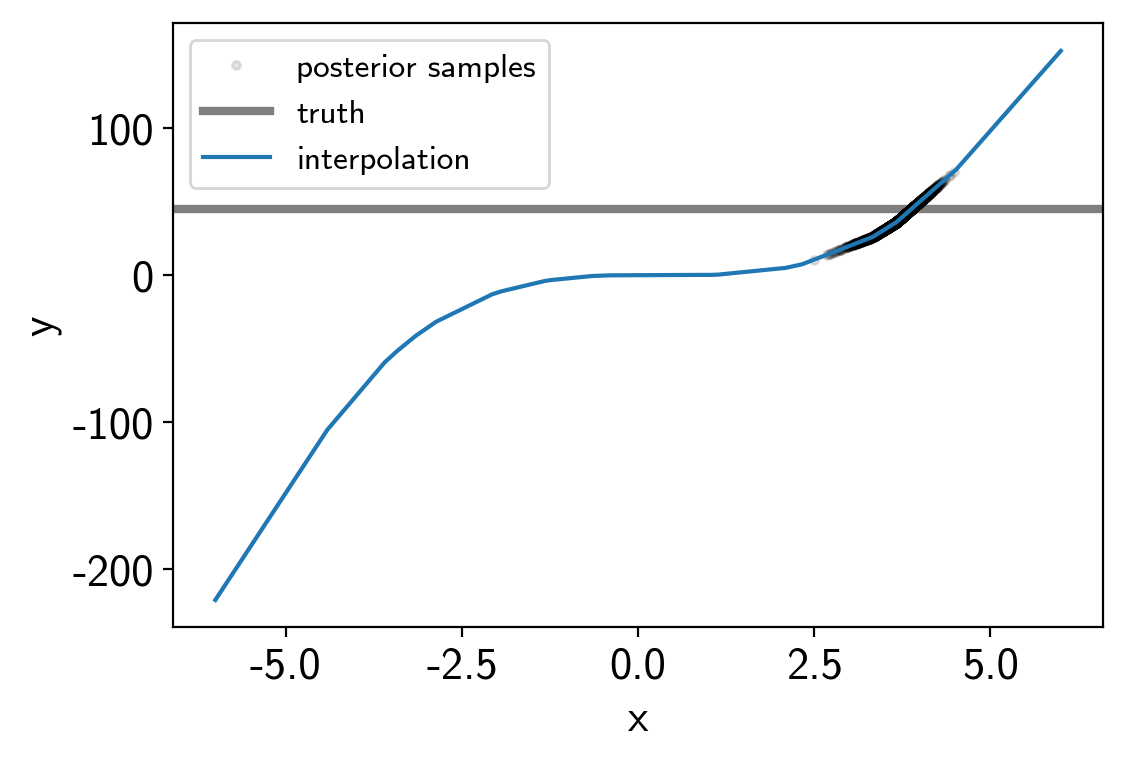

In [5]:
t = np.linspace(-6, 6, 5000)
plt.plot(trace["x"][:, 0, 0], trace["y"], ".k", alpha=0.1, label="posterior samples")
plt.axhline(truth, color="k", lw=3, alpha=0.5, label="truth")
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

## A 2D example

In this case, we'll interpolate a 2D function. This one is a hard one because the posterior is a ring, but it demonstrates the principle.

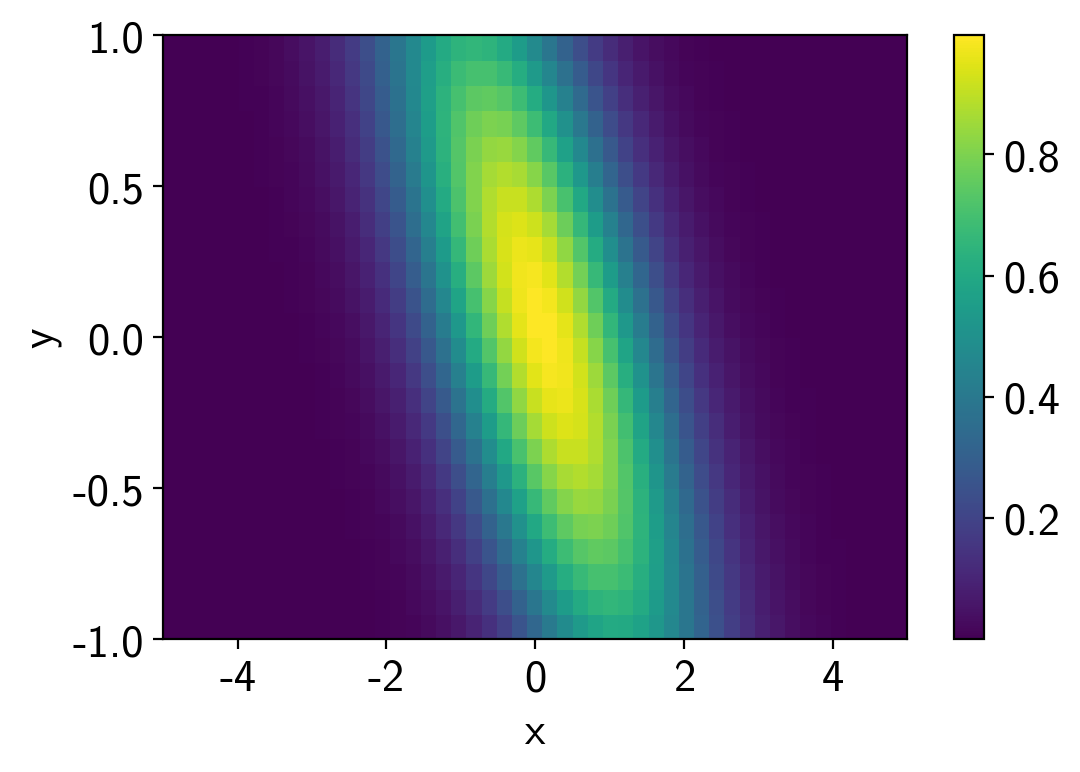

In [6]:
points = [
    np.linspace(-5, 5, 50),
    np.linspace(-1, 1, 25),
]
values = np.exp(-0.5*(points[0]**2)[:, None] - 0.5*(points[1]**2 / 0.5)[None, :] - points[0][:, None]*points[1][None, :])

interpolator = xo.interp.RegularGridInterpolator(points, values[:, :, None], nout=1)

plt.pcolor(points[0], points[1], values.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y");

Set things up and sample.

In [7]:
import theano.tensor as tt

data_mu = 0.6
data_sd = 0.1

with pm.Model() as model:
    
    xval = pm.Uniform("x", lower=-5, upper=5, shape=(1,))
    yval = pm.Uniform("y", lower=-1, upper=1, shape=(1,))
    xtest = tt.stack([xval, yval], axis=-1)
    
    mod = interpolator.evaluate(xtest)
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=4000, tune=4000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [y, x]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 105/32000 [00:00<00:30, 1031.27draws/s]

Sampling 4 chains:   1%|          | 315/32000 [00:00<00:26, 1215.43draws/s]

Sampling 4 chains:   2%|▏         | 622/32000 [00:00<00:21, 1483.99draws/s]

Sampling 4 chains:   3%|▎         | 913/32000 [00:00<00:17, 1738.72draws/s]

Sampling 4 chains:   4%|▍         | 1208/32000 [00:00<00:15, 1982.05draws/s]

Sampling 4 chains:   5%|▍         | 1497/32000 [00:00<00:13, 2188.08draws/s]

Sampling 4 chains:   6%|▌         | 1784/32000 [00:00<00:12, 2355.32draws/s]

Sampling 4 chains:   7%|▋         | 2099/32000 [00:00<00:11, 2546.67draws/s]

Sampling 4 chains:   8%|▊         | 2427/32000 [00:00<00:10, 2729.49draws/s]

Sampling 4 chains:   8%|▊         | 2717/32000 [00:01<00:10, 2739.92draws/s]

Sampling 4 chains:   9%|▉         | 3003/32000 [00:01<00:10, 2736.32draws/s]

Sampling 4 chains:  10%|█         | 3331/32000 [00:01<00:09, 2874.15draws/s]

Sampling 4 chains:  11%|█▏        | 3651/32000 [00:01<00:09, 2961.55draws/s]

Sampling 4 chains:  12%|█▏        | 3971/32000 [00:01<00:09, 3028.40draws/s]

Sampling 4 chains:  13%|█▎        | 4285/32000 [00:01<00:09, 3056.90draws/s]

Sampling 4 chains:  14%|█▍        | 4594/32000 [00:01<00:09, 2961.63draws/s]

Sampling 4 chains:  15%|█▌        | 4894/32000 [00:01<00:09, 2939.24draws/s]

Sampling 4 chains:  16%|█▌        | 5191/32000 [00:01<00:09, 2930.50draws/s]

Sampling 4 chains:  17%|█▋        | 5515/32000 [00:01<00:08, 3015.16draws/s]

Sampling 4 chains:  18%|█▊        | 5819/32000 [00:02<00:08, 2959.79draws/s]

Sampling 4 chains:  19%|█▉        | 6151/32000 [00:02<00:08, 3058.63draws/s]

Sampling 4 chains:  20%|██        | 6459/32000 [00:02<00:08, 2985.81draws/s]

Sampling 4 chains:  21%|██        | 6760/32000 [00:02<00:08, 2981.47draws/s]

Sampling 4 chains:  22%|██▏       | 7060/32000 [00:02<00:08, 2984.72draws/s]

Sampling 4 chains:  23%|██▎       | 7371/32000 [00:02<00:08, 3020.09draws/s]

Sampling 4 chains:  24%|██▍       | 7728/32000 [00:02<00:07, 3164.09draws/s]

Sampling 4 chains:  25%|██▌       | 8047/32000 [00:02<00:07, 3100.84draws/s]

Sampling 4 chains:  26%|██▌       | 8359/32000 [00:02<00:07, 3064.44draws/s]

Sampling 4 chains:  27%|██▋       | 8667/32000 [00:02<00:07, 2970.51draws/s]

Sampling 4 chains:  28%|██▊       | 8966/32000 [00:03<00:07, 2911.98draws/s]

Sampling 4 chains:  29%|██▉       | 9259/32000 [00:03<00:08, 2838.08draws/s]

Sampling 4 chains:  30%|██▉       | 9555/32000 [00:03<00:07, 2871.34draws/s]

Sampling 4 chains:  31%|███       | 9892/32000 [00:03<00:07, 3004.57draws/s]

Sampling 4 chains:  32%|███▏      | 10195/32000 [00:03<00:07, 2971.57draws/s]

Sampling 4 chains:  33%|███▎      | 10553/32000 [00:03<00:06, 3130.00draws/s]

Sampling 4 chains:  34%|███▍      | 10870/32000 [00:03<00:06, 3084.40draws/s]

Sampling 4 chains:  35%|███▍      | 11182/32000 [00:03<00:06, 3061.16draws/s]

Sampling 4 chains:  36%|███▌      | 11490/32000 [00:03<00:06, 2954.91draws/s]

Sampling 4 chains:  37%|███▋      | 11829/32000 [00:04<00:06, 3072.12draws/s]

Sampling 4 chains:  38%|███▊      | 12139/32000 [00:04<00:06, 3005.18draws/s]

Sampling 4 chains:  39%|███▉      | 12464/32000 [00:04<00:06, 3074.25draws/s]

Sampling 4 chains:  40%|███▉      | 12787/32000 [00:04<00:06, 3116.13draws/s]

Sampling 4 chains:  41%|████      | 13101/32000 [00:04<00:06, 2956.57draws/s]

Sampling 4 chains:  42%|████▏     | 13400/32000 [00:04<00:06, 2892.00draws/s]

Sampling 4 chains:  43%|████▎     | 13692/32000 [00:04<00:06, 2874.89draws/s]

Sampling 4 chains:  44%|████▎     | 13999/32000 [00:04<00:06, 2929.72draws/s]

Sampling 4 chains:  45%|████▍     | 14317/32000 [00:04<00:05, 3000.38draws/s]

Sampling 4 chains:  46%|████▌     | 14619/32000 [00:04<00:05, 2967.08draws/s]

Sampling 4 chains:  47%|████▋     | 14952/32000 [00:05<00:05, 3066.30draws/s]

Sampling 4 chains:  48%|████▊     | 15261/32000 [00:05<00:05, 2993.95draws/s]

Sampling 4 chains:  49%|████▊     | 15585/32000 [00:05<00:05, 3059.71draws/s]

Sampling 4 chains:  50%|████▉     | 15893/32000 [00:05<00:05, 3022.28draws/s]

Sampling 4 chains:  51%|█████     | 16212/32000 [00:05<00:05, 3068.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16520/32000 [00:05<00:05, 2963.08draws/s]

Sampling 4 chains:  53%|█████▎    | 16865/32000 [00:05<00:04, 3094.01draws/s]

Sampling 4 chains:  54%|█████▎    | 17198/32000 [00:05<00:04, 3157.31draws/s]

Sampling 4 chains:  55%|█████▍    | 17516/32000 [00:05<00:04, 3130.10draws/s]

Sampling 4 chains:  56%|█████▌    | 17861/32000 [00:05<00:04, 3217.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18185/32000 [00:06<00:04, 3166.52draws/s]

Sampling 4 chains:  58%|█████▊    | 18513/32000 [00:06<00:04, 3199.24draws/s]

Sampling 4 chains:  59%|█████▉    | 18834/32000 [00:06<00:04, 3104.61draws/s]

Sampling 4 chains:  60%|██████    | 19211/32000 [00:06<00:03, 3277.37draws/s]

Sampling 4 chains:  61%|██████    | 19543/32000 [00:06<00:03, 3250.82draws/s]

Sampling 4 chains:  62%|██████▏   | 19871/32000 [00:06<00:03, 3181.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20192/32000 [00:06<00:03, 3129.70draws/s]

Sampling 4 chains:  64%|██████▍   | 20507/32000 [00:06<00:03, 3133.42draws/s]

Sampling 4 chains:  65%|██████▌   | 20858/32000 [00:06<00:03, 3237.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21184/32000 [00:07<00:03, 3170.75draws/s]

Sampling 4 chains:  67%|██████▋   | 21537/32000 [00:07<00:03, 3268.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21866/32000 [00:07<00:03, 3210.81draws/s]

Sampling 4 chains:  69%|██████▉   | 22200/32000 [00:07<00:03, 3245.45draws/s]

Sampling 4 chains:  70%|███████   | 22526/32000 [00:07<00:03, 3153.94draws/s]

Sampling 4 chains:  71%|███████▏  | 22857/32000 [00:07<00:02, 3197.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23178/32000 [00:07<00:02, 3140.55draws/s]

Sampling 4 chains:  74%|███████▎  | 23526/32000 [00:07<00:02, 3234.24draws/s]

Sampling 4 chains:  75%|███████▍  | 23851/32000 [00:07<00:02, 3118.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24165/32000 [00:07<00:02, 3098.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24497/32000 [00:08<00:02, 3160.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24815/32000 [00:08<00:02, 3154.77draws/s]

Sampling 4 chains:  79%|███████▊  | 25170/32000 [00:08<00:02, 3262.56draws/s]

Sampling 4 chains:  80%|███████▉  | 25498/32000 [00:08<00:02, 3055.96draws/s]

Sampling 4 chains:  81%|████████  | 25831/32000 [00:08<00:01, 3132.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26186/32000 [00:08<00:01, 3245.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26514/32000 [00:08<00:01, 3197.76draws/s]

Sampling 4 chains:  84%|████████▍ | 26848/32000 [00:08<00:01, 3237.53draws/s]

Sampling 4 chains:  85%|████████▍ | 27174/32000 [00:08<00:01, 3193.11draws/s]

Sampling 4 chains:  86%|████████▌ | 27495/32000 [00:09<00:01, 3144.08draws/s]

Sampling 4 chains:  87%|████████▋ | 27811/32000 [00:09<00:01, 3068.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28120/32000 [00:09<00:01, 3062.23draws/s]

Sampling 4 chains:  89%|████████▉ | 28448/32000 [00:09<00:01, 3123.09draws/s]

Sampling 4 chains:  90%|████████▉ | 28787/32000 [00:09<00:01, 3192.98draws/s]

Sampling 4 chains:  91%|█████████ | 29108/32000 [00:09<00:00, 3070.34draws/s]

Sampling 4 chains:  92%|█████████▏| 29437/32000 [00:09<00:00, 3132.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29757/32000 [00:09<00:00, 3151.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30074/32000 [00:09<00:00, 2838.77draws/s]

Sampling 4 chains:  95%|█████████▍| 30365/32000 [00:09<00:00, 2765.41draws/s]

Sampling 4 chains:  96%|█████████▌| 30647/32000 [00:10<00:00, 2651.60draws/s]

Sampling 4 chains:  97%|█████████▋| 30917/32000 [00:10<00:00, 2592.50draws/s]

Sampling 4 chains:  97%|█████████▋| 31180/32000 [00:10<00:00, 2573.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31440/32000 [00:10<00:00, 2545.83draws/s]

Sampling 4 chains:  99%|█████████▉| 31697/32000 [00:10<00:00, 2532.29draws/s]

Sampling 4 chains: 100%|█████████▉| 31952/32000 [00:10<00:00, 2007.24draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [00:10<00:00, 2959.09draws/s]

The number of effective samples is smaller than 10% for some parameters.


And here are the results:

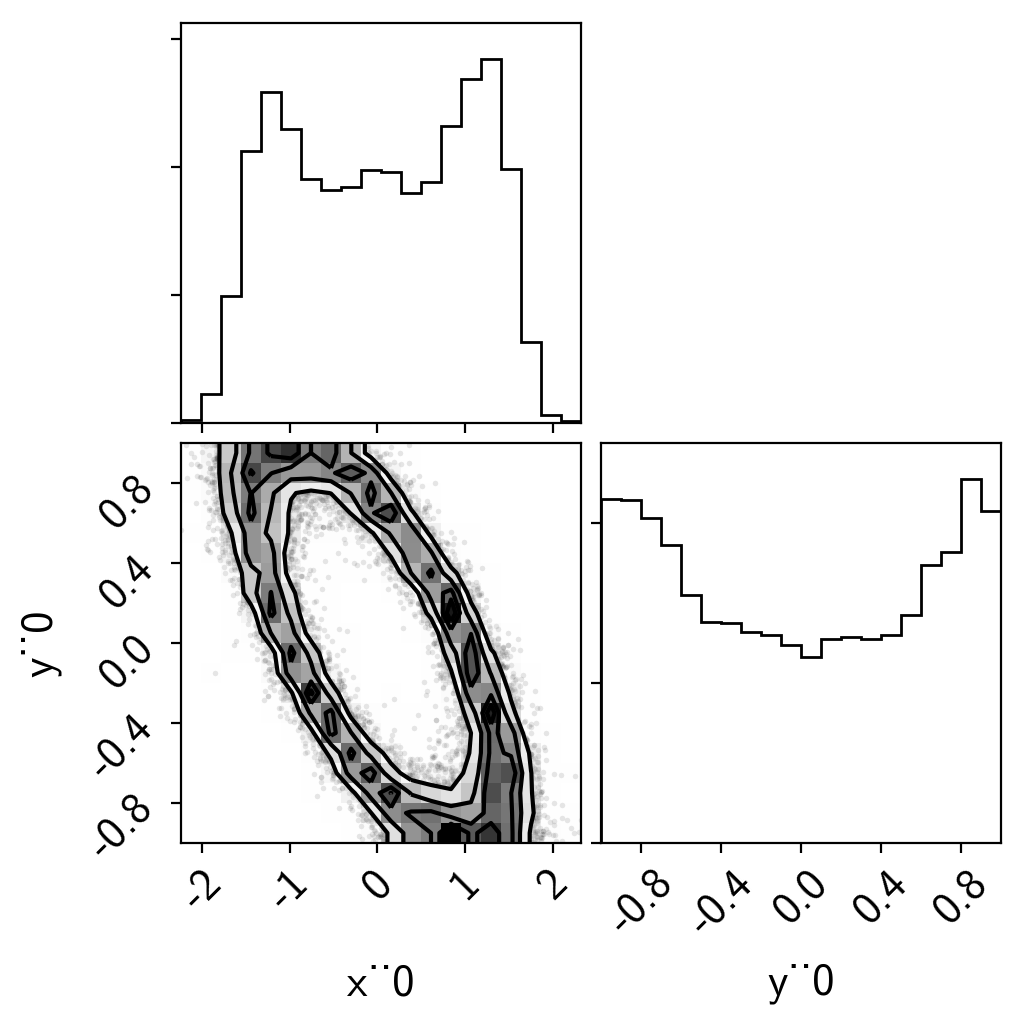

In [8]:
import corner
samples = pm.trace_to_dataframe(trace)
corner.corner(samples);